In [1]:
# Let's start by opening and reading a small part of the file to understand its structure
file_path = '../data/All mail Including Spam and Trash.mbox'

# Read the first part of the file to understand its structure
with open(file_path, 'r', encoding='utf-8') as file:
    content_preview = file.read(1024)  # Read the first 1024 characters for a preview

content_preview

'From 1789661171270937312@xxx Thu Feb 01 02:18:14 +0000 2024\nX-GM-THRID: 1789661171270937312\nX-Gmail-Labels: Spam,Category Promotions,Unread\nDelivered-To: jengabuilding90@gmail.com\nReceived: by 2002:a05:7300:d027:b0:106:2596:8029 with SMTP id ni39csp150111dyb;\n        Wed, 31 Jan 2024 18:18:14 -0800 (PST)\nX-Received: by 2002:a81:bb52:0:b0:5fb:c044:f087 with SMTP id a18-20020a81bb52000000b005fbc044f087mr3234127ywl.35.1706753894003;\n        Wed, 31 Jan 2024 18:18:14 -0800 (PST)\nARC-Seal: i=2; a=rsa-sha256; t=1706753893; cv=pass;\n        d=google.com; s=arc-20160816;\n        b=rYXtUHzzPuhbR+c1ilMXjQs+Dzc40gDBgVQS+V9o8HTS7hBOTdJzGwkkBOE+pUbcz8\n         YyVlAwzN93X/GtBNbIjgjMHhvnWHpwLkBTnH14a58PYfHplSi68/NAg2CUck9t+1jPgH\n         ZVGz9TB88im8rAXhGCKml/Bxo/evkJAFRhMh2BCMjPnJ9RQlKsw3WmLkhrd3jCL3FYo1\n         kIPPE0MCRMZ/v4uaPnWyqNOOv5HMXFHOTCu1UDhTDfPvQ+zMVhYwJvuB/wvdqjqQzURJ\n         4w7TaBCKvuYxRzzZAs2BMcvxLfcafFYB+bzKKr8Ysf8dFDILVGE9+QonEvxn2Li+6Una\n         MZ8g==\nARC-Mess

In [2]:
# Re-import necessary libraries and redefine the function after the code execution state was reset
from email.header import decode_header
import mailbox
import json

# Redefine function to include email content (both plain text and HTML if available)
def extract_email_content_and_details(msg):
    subject = msg.get('Subject', '')
    # Decode the subject line
    decoded_headers = decode_header(subject)
    subject = ''.join([text.decode(charset or 'utf-8') if isinstance(text, bytes) else text for text, charset in decoded_headers])


    details = {"from": msg.get('From', ''), "delivered_to": msg.get('Delivered-To', ''),
               "subject": subject, "date": msg.get('Date', ''), "labels": msg.get('X-Gmail-Labels', ''),
               "content_plain": "", "content_html": ""}

    if msg.is_multipart():
        for part in msg.walk():
            content_type = part.get_content_type()
            content_disposition = part.get("Content-Disposition")
            
            if content_disposition:  # Ignore attachments/html images
                continue
            if content_type == "text/plain":
                details["content_plain"] = part.get_payload(decode=True).decode('utf-8', errors='ignore')
            elif content_type == "text/html":
                details["content_html"] = part.get_payload(decode=True).decode('utf-8', errors='ignore')
    else:
        content_type = msg.get_content_type()
        if content_type == "text/plain":
            details["content_plain"] = msg.get_payload(decode=True).decode('utf-8', errors='ignore')
        elif content_type == "text/html":
            details["content_html"] = msg.get_payload(decode=True).decode('utf-8', errors='ignore')
    return details

# Load the mbox file again
file_path = '../data/All mail Including Spam and Trash.mbox'
mbox = mailbox.mbox(file_path)

# Process a limited number of emails to demonstrate inclusion of content
emails_all = [extract_email_content_and_details(msg) for msg in list(mbox)]

# Save the JSON data to a file (limited set)
json_file_path = '../data/emails_extracted.json'
with open(json_file_path, 'w', encoding='utf-8') as json_file:
    json.dump(emails_all, json_file, indent=4)

In [3]:
import os
from bs4 import BeautifulSoup, Comment

json_file_path = '../data/emails_extracted.json'
with open(json_file_path, 'r', encoding='utf-8') as json_file:
    emails_all = json.load(json_file)

output_text_file_path = '../data/email_contents_plain.txt'
if os.path.exists(output_text_file_path):
    os.remove(output_text_file_path)  # Remove the file if it already exists

# Process the mbox and write email contents to a text file
for detail in emails_all:
    with open(output_text_file_path, 'a', encoding='utf-8') as file:
        if detail['content_plain']:
            # remove empty lines
            detail['content_plain'] = '\n'.join([line for line in detail['content_plain'].split('\n') if line.strip() != ''])
            file.write(detail['content_plain'] + '\n\n')
        if detail['content_html']:
            bs = BeautifulSoup(detail['content_html'], 'html.parser')

            # Remove <script> and <style> tags and their contents
            for script in bs(["script", "style"]):
                script.decompose()

            # Remove comments
            for comment in bs.findAll(text=lambda text: isinstance(text, Comment)):
                comment.extract()

            raw_text = bs.get_text()
            # remove empty lines
            raw_text = '\n'.join([line for line in raw_text.split('\n') if line.strip() != ''])
            file.write(raw_text + '\n\n')
        file.write('=========================================') # Separate emails with a line

/var/folders/h6/x4_dgx2j0jl1bfcrymzs408m0000gn/T/ipykernel_9842/560467996.py:27: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  for comment in bs.findAll(text=lambda text: isinstance(text, Comment)):


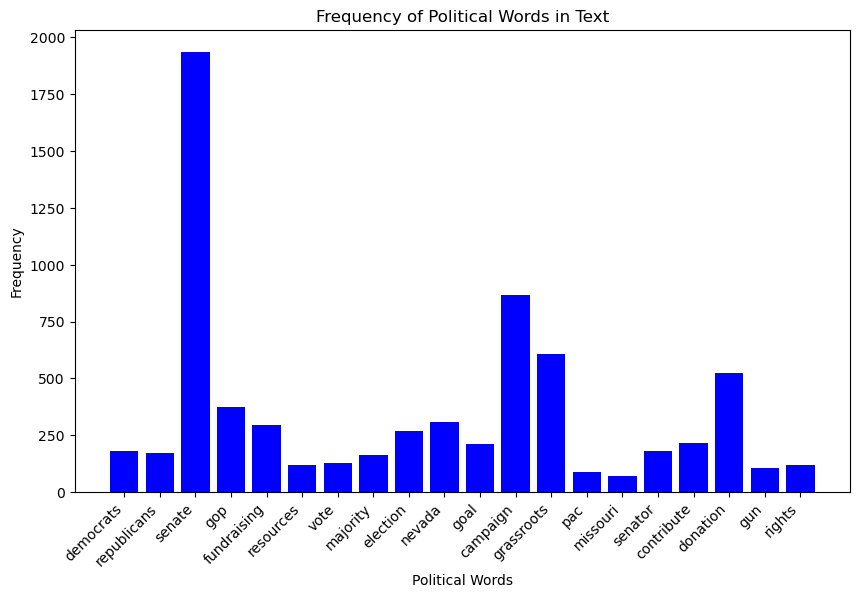

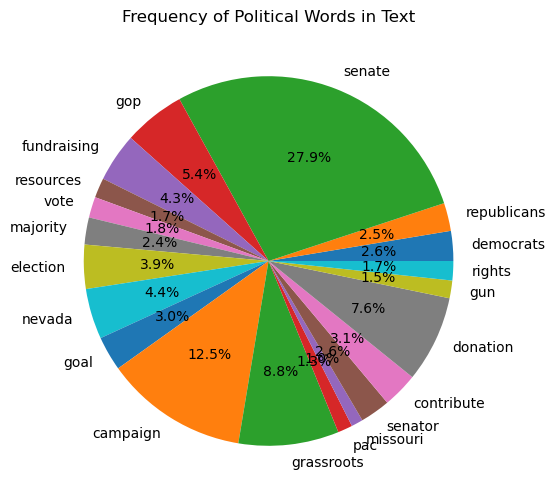

In [4]:
from matplotlib import pyplot as plt

political_words = ['democrats', 'republicans', 'senate', 'gop', 'fundraising', 'resources', 'vote', 'majority', 'election', 'nevada',  'goal', 'campaign', 'grassroots', 'pac', 'missouri', 'senator', 'contribute', 'donation', 'gun', 'rights']

# Load the provided text to scan for these words
text_path = "../data/email_contents_plain.txt"
with open(text_path, 'r', encoding='utf-8') as file:
    text = file.read().lower()  # Convert text to lowercase to match case-insensitively

# Tokenize the text and count the frequency of each political word
from collections import Counter
word_counts = Counter(text.split())
political_word_frequencies = {word: word_counts[word] for word in political_words if word in word_counts}

# Extract words and their frequencies for plotting
words = list(political_word_frequencies.keys())
frequencies = list(political_word_frequencies.values())

plt.figure(figsize=(10, 6))
plt.bar(words, frequencies, color='blue')
plt.xlabel('Political Words')
plt.ylabel('Frequency')
plt.title('Frequency of Political Words in Text')
plt.xticks(rotation=45, ha="right")
# save the bar chart
plt.savefig('../result/political_words_bar_chart.png')
plt.show()
# pie chart
plt.figure(figsize=(10, 6))
plt.pie(frequencies, labels=words, autopct='%1.1f%%')
plt.title('Frequency of Political Words in Text')
# save the pie chart
plt.savefig('../result/political_words_pie_chart.png')
plt.show()

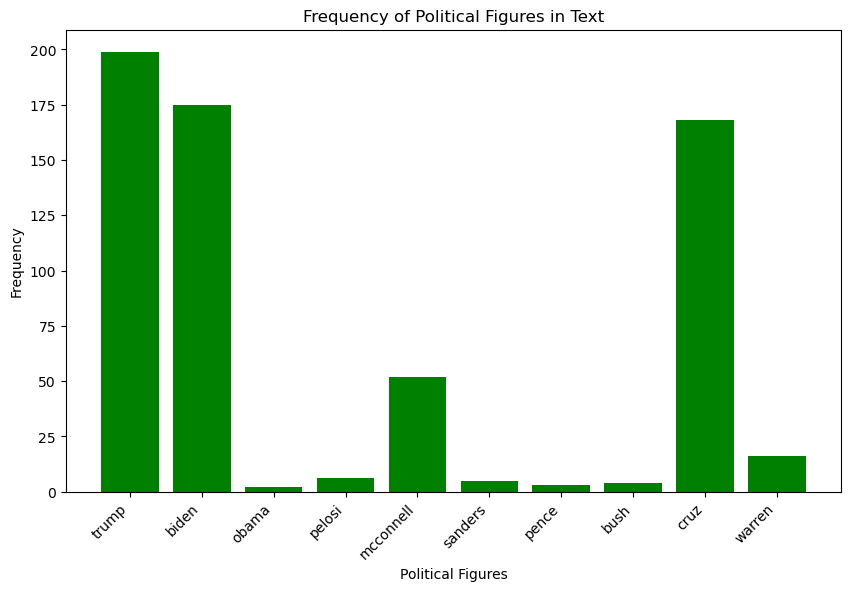

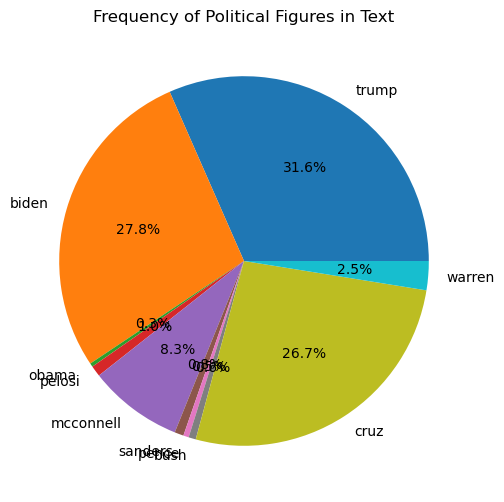

In [5]:
political_figures = ['trump', 'biden', 'obama', 'clinton', 'pelosi', 'mcconnell', 'sanders', 'harris', 'pence', 'romney', 'bush', 'cruz', 'warren', 'soros', 'koch', 'soros', 'koch', 'putin', 'xi', 'kim', 'merkel', 'macron', 'trudeau', 'modi', 'abe', 'erdogan']
political_figures = [figure.lower() for figure in political_figures]
political_figures_frequencies = {figure: word_counts[figure] for figure in political_figures if figure in word_counts}

# Extract figures and their frequencies for plotting
figures = list(political_figures_frequencies.keys())
frequencies = list(political_figures_frequencies.values())

plt.figure(figsize=(10, 6))
plt.bar(figures, frequencies, color='green')
plt.xlabel('Political Figures')
plt.ylabel('Frequency')
plt.title('Frequency of Political Figures in Text')
plt.xticks(rotation=45, ha="right")
# save the bar chart
plt.savefig('../result/political_figures_bar_chart.png')
plt.show()
# pie chart
plt.figure(figsize=(10, 6))
plt.pie(frequencies, labels=figures, autopct='%1.1f%%')
plt.title('Frequency of Political Figures in Text')
# save the pie chart
plt.savefig('../result/political_figures_pie_chart.png')
plt.show()

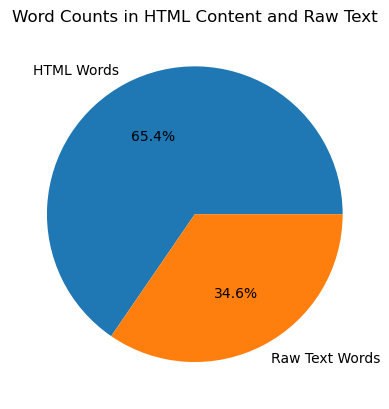

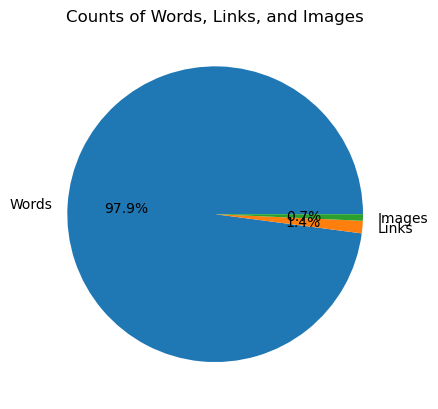

In [6]:
# Count the words, links and images in the HTML content and raw text
html_content = [email['content_html'] for email in emails_all if email['content_html']]
raw_text = [email['content_plain'] for email in emails_all if email['content_plain']]
html_content = ' '.join(html_content)
raw_text = ' '.join(raw_text)

# Count the words, links and images in the HTML content and raw text
from bs4 import BeautifulSoup
bs = BeautifulSoup(html_content, 'html.parser')
html_words = bs.get_text().split()
html_links = [link.get('href') for link in bs.find_all('a', href=True)]
html_images = [image.get('src') for image in bs.find_all('img', src=True)]

# Count the words in the raw text
raw_text_words = raw_text.split()

# Plot them
html_word_count = len(html_words)
raw_text_word_count = len(raw_text_words)
# Merge the word counts
total_word_count = html_word_count + raw_text_word_count

# Create lists for the pie chart
labels = ['HTML Words', 'Raw Text Words']
counts = [html_word_count, raw_text_word_count]

# Create a pie chart
fig, ax = plt.subplots()
ax.pie(counts, labels=labels, autopct='%1.1f%%')

# Add a title
ax.set_title('Word Counts in HTML Content and Raw Text')

# save the pie chart
plt.savefig('../result/word_counts_pie_chart.png')
plt.show()

# Merge all words together
all_words = html_words + raw_text_words
all_word_count = len(all_words)

# Count the number of links and images
html_link_count = len(html_links)
html_image_count = len(html_images)

# Create lists for the pie chart
labels = ['Words', 'Links', 'Images']
counts = [all_word_count, html_link_count, html_image_count]

# Create a pie chart
fig, ax = plt.subplots()
ax.pie(counts, labels=labels, autopct='%1.1f%%')

# Add a title
ax.set_title('Counts of Words, Links, and Images')

# save the pie chart
plt.savefig('../result/word_link_image_counts_pie_chart.png')
plt.show()